# 快速智能体 - 快速构建 SQL 智能体！

<img src="./assets/LC_L1_top.png" align="left" width="500">

## 设置

加载和/或检查所需的环境变量

In [ ]:
from dotenv import load_dotenv
from env_utils import doublecheck_env, doublecheck_pkgs

# 从 .env 文件加载环境变量
load_dotenv()

# 检查并打印结果
doublecheck_env("example.env")  # 检查环境变量
doublecheck_pkgs(pyproject_path="pyproject.toml", verbose=True)   # 检查包

In [8]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

定义运行时上下文，为智能体和工具提供数据库访问权限。

In [ ]:
from dataclasses import dataclass

from langchain_community.utilities import SQLDatabase


# 定义上下文结构以支持依赖注入
@dataclass
class RuntimeContext:
    db: SQLDatabase

<b>⚠️ 安全提示：</b>本演示不包含对 LLM 生成命令的过滤。在生产环境中，你需要限制 LLM 生成命令的范围。⚠️   
此工具将连接到数据库。注意使用 `get_runtime` 来访问图的**运行时上下文**。

In [ ]:
from langchain_core.tools import tool
from langgraph.runtime import get_runtime

@tool
def execute_sql(query: str) -> str:
    """执行 SQLite 命令并返回结果。"""
    runtime = get_runtime(RuntimeContext)
    db = runtime.context.db

    try:
        return db.run(query)
    except Exception as e:
        return f"Error: {e}"

添加系统提示以定义智能体的行为。

In [ ]:
SYSTEM_PROMPT = """你是一个谨慎的 SQLite 分析师。

规则：
- 逐步思考。
- 当你需要数据时，使用一个 SELECT 查询调用工具 `execute_sql`。
- 只读操作；不要执行 INSERT/UPDATE/DELETE/ALTER/DROP/CREATE/REPLACE/TRUNCATE。
- 除非用户明确要求，否则输出限制为 5 行。
- 如果工具返回 'Error:'，修改 SQL 并重试。
- 优先使用明确的列列表；避免使用 SELECT *。
"""

创建你的智能体！添加一个模型、工具、提示和运行时访问，然后开始！你可以从我们的[集成列表](https://docs.langchain.com/oss/python/integrations/providers)中选择多种智能体。

In [12]:
from langchain.agents import create_agent
from langchain_deepseek import ChatDeepSeek

agent = create_agent(
    model="deepseek-chat",
    tools=[execute_sql],
    system_prompt=SYSTEM_PROMPT,
    context_schema=RuntimeContext,
)

这里展示了智能体的 ReAct 循环。

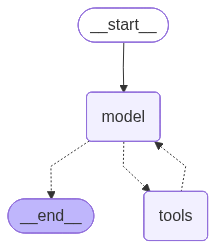

In [13]:
from IPython.display import Image, display

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

运行一些查询。注意：
- 智能体没有数据库模式，需要独立发现它。
- 智能体可能会犯错误！通过返回错误消息，智能体可以自我纠正查询。
- 注意你使用 `agent.stream` 来调用智能体。
    - 该命令和 `pretty_print` 显示在模型和工具之间传递信息的**消息**。
- 注意智能体在调用之间不会记住模式...稍后会详细介绍！

In [14]:
question = "Which table has the largest number of entries?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

/Users/jayshen/dev/lca-langchainV1-essentials/.venv/lib/python3.12/site-packages/pydantic/v1/main.py:1054: UserWarning: LangSmith now uses UUID v7 for run and trace identifiers. This warning appears when passing custom IDs. Please use: from langsmith import uuid7
            id = uuid7()
Future versions will require UUID v7.
  input_data = validator(cls_, input_data)


================================ Human Message =================================

Which table has the largest number of entries?
================================== Ai Message ==================================

I'll help you find which table has the largest number of entries. Let me first check what tables are available in the database.
Tool Calls:
  execute_sql (call_00_t4AsIZBjy7uY6s2Uk8EgbOz2)
 Call ID: call_00_t4AsIZBjy7uY6s2Uk8EgbOz2
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table';
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================

Now I'll count the number of entries in each table to determine which one has the most records:
Tool Calls:
  execute_sql (call_00_kVkfue7sULW

In [9]:
question = "Which genre on average has the longest tracks?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which genre on average has the longest tracks?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_HYISrfBIIfMxf2aJBPTkEXcP)
 Call ID: call_HYISrfBIIfMxf2aJBPTkEXcP
  Args:
    query: SELECT g.Name AS genre_name, AVG(t.Milliseconds)/1000.0 AS avg_seconds, AVG(t.Milliseconds) AS avg_milliseconds
FROM genres g
JOIN tracks t ON g.GenreId = t.GenreId
GROUP BY g.GenreId, g.Name
ORDER BY avg_milliseconds DESC
LIMIT 1;
================================= Tool Message =================================
Name: execute_sql

Error: (sqlite3.OperationalError) no such table: genres
[SQL: SELECT g.Name AS genre_name, AVG(t.Milliseconds)/1000.0 AS avg_seconds, AVG(t.Milliseconds) AS avg_milliseconds
FROM genres g
JOIN tracks t ON g.GenreId = t.GenreId
GROUP BY g.GenreId, g.Name
ORDER BY avg_milliseconds DESC
LIMIT 1;]
(Background on this error at: https://sqlalche

In [15]:
question = "Please list all of the tables"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Please list all of the tables
================================== Ai Message ==================================

I'll help you list all the tables in the SQLite database. Let me execute a query to retrieve the table names.
Tool Calls:
  execute_sql (call_00_deshC9gPB0kDelQvGXoqoXDv)
 Call ID: call_00_deshC9gPB0kDelQvGXoqoXDv
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table';
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================

Here are all the tables in the SQLite database:

1. Album
2. Artist
3. Customer
4. Employee
5. Genre
6. Invoice
7. InvoiceLine
8. MediaType
9. Playlist
10. PlaylistTrack
11. Tra

**在这里创建你自己的查询！** 添加一些你自己的问题。

In [ ]:
question = "在这里尝试你自己的查询"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

### 让我们在 Studio 中尝试一下